In [ ]:
class RasterTilesDataset(Dataset):
    def __init__(self, dem_dir, so_dir, transform=None):
        """
        Custom dataset to load DEM and SO tiles.

        :param dem_dir: Directory where DEM tiles are stored.
        :param so_dir: Directory where SO tiles are stored.
        :param transform: Optional transform to be applied on a sample.
        """
        self.dem_dir = dem_dir
        self.so_dir = so_dir
        self.transform = transform

        # Extracting unique identifiers (coordinates) from DEM filenames
        self.tile_identifiers = [f.split('_')[2:4] for f in os.listdir(dem_dir) if 'dem_tile' in f]

    def __len__(self):
        return len(self.tile_identifiers)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        tile_id = self.tile_identifiers[idx]
        dem_file = os.path.join(self.dem_dir, f'dem_tile_{tile_id[0]}_{tile_id[1]}')
        so_file = os.path.join(self.so_dir, f'so_tile_{tile_id[0]}_{tile_id[1]}')

        dem_image = Image.open(dem_file)
        so_image = Image.open(so_file)

        dem_array = np.array(dem_image)
        so_array = np.array(so_image)

        sample = {'DEM': dem_array, 'SO': so_array}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [1]:
# from model import *
# from dataset import *


# from torch.utils.data import DataLoader, random_split


dem_dir = '/home/macula/SMATousi/Gullies/ground_truth/google_api/training_process/DEM2SO/dem2so/dem'
so_dir = '/home/macula/SMATousi/Gullies/ground_truth/google_api/training_process/DEM2SO/dem2so/so'

# epochs=5
# batch_size=1
# lr=0.001
# val_percent=0.1
# save_cp=True
# img_scale=0.5


# dataset = RasterTilesDataset(dem_dir=dem_dir, so_dir=so_dir)

# n_train = len(dataset) - n_val
# train, val = random_split(dataset, [n_train, n_val])
# train_loader = DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)
# val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True, drop_last=True)


In [ ]:
n_val = int(len(dataset) * val_percent)
n_train = len(dataset) - n_val
train, val = random_split(dataset, [n_train, n_val])
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True, drop_last=True)


In [ ]:
sample = next(iter(train_loader))

In [ ]:
sample['SO'].shape

In [2]:
from model import *
from dataset import *
from utils import *

In [3]:
transform = RasterTransform()
dataset = RasterTilesDataset(dem_dir=dem_dir, so_dir=so_dir, transform=transform)

In [5]:
batch_size = 4
learning_rate = 0.0001
epochs = 5
number_of_workers = 1
image_size = 128
val_percent = 0.1
n_val = int(len(dataset) * val_percent)
n_train = len(dataset) - n_val
train, val = random_split(dataset, [n_train, n_val])
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=number_of_workers, pin_memory=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, num_workers=number_of_workers, pin_memory=True, drop_last=True)


In [6]:
batch = next(iter(train_loader))

In [7]:
dem_image = batch['DEM']
so_image = batch['SO']

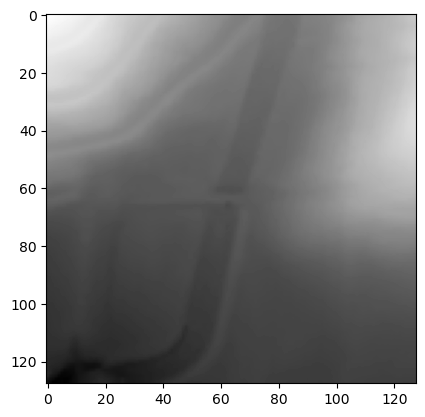

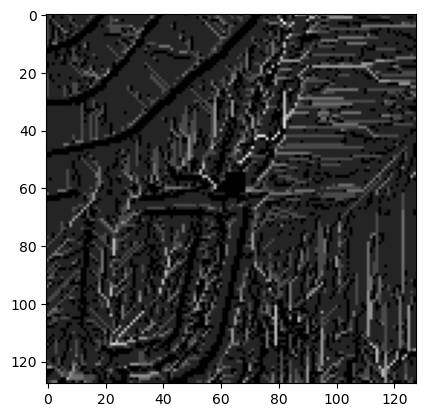

In [12]:
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(dem_image[0].squeeze(), cmap='gray')
plt.figure()
plt.imshow(so_image[0].squeeze(), cmap='gray')

In [13]:
test = so_image[0].squeeze()

In [15]:
test.min()

tensor(0)